In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import outlaw
import outlaw.berry as berry
import outlaw.quad as quad
import numpy as np
import jax.numpy as jnp
import jax
import time
import outlaw.inla as inla
import matplotlib.pyplot as plt
import numpyro.distributions as dist
from functools import partial
from itertools import combinations

from lewis import lewis
from lewis import batch
from berrylib import grid
from lewis import grid as lewgrid
from berrylib import binomial

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Lei Example

The following description is a clinical trial design using a Bayesian model with early-stopping rules for futility or efficacy of a drug.
This design was explicitly requested to be studied by an FDA member (Lei) in the CID team.

> The following is a randomized, double-blind, placebo-controlled two-stage adaptive design intended to identify an optimal treatment regimen 
> from three possible regimens (for example, different dosages or different combinations of agents) and 
> to assess the efficacy of that regimen with respect to a primary binary response endpoint measured at month 6.
> 
> In Stage 1, one of four experimental regimens will be selected, or the trial will stop for futility. 
> In this stage, a minimum of 200 and a maximum of 400 will be randomized 1:1:1:1 to one of the three experimental arms or one placebo arm. 
> Interim analyses will be conducted after 200, 300 and 400 subjects have been enrolled to select the best experimental regimen and to potentially stop 
> the trial for futility. 
> If an experimental regimen is dropped for futility at an interim analysis, 
> the next 100 subjects to be randomized will be allocated equally among the remaining arms in the study. 
> At each of these three analysis time points (N = 200, 300, 400), 
> the probabilities of being the best regimen (PrBest) and predictive probability of success (PPS) 
> are calculated for each experimental regimen using a Bayesian approach, 
> and the trial will either stop for futility, 
> continue to the next interim analysis, 
> or proceed to Stage 2 depending on the results of these PrBest and PPS calculations.
> 
> In Stage 2, a minimum of 200 and a maximum of 400 additional subjects will be randomized 1:1 to the chosen regimen or placebo. 
> The two groups (pooling both Stage 1 and Stage 2 subjects) will be compared for efficacy and futility assessment at an interim analysis 
> after 200 subjects have been enrolled in Stage 2, 
> and for efficacy at a final analysis after 400 subjects have been enrolled in Stage 2 and fully followed-up for response. 
> The study may be stopped for futility or efficacy based on PPS at the interim analysis. 
> If the study continues to the final analysis, 
> the posterior distribution of the difference in response rates between placebo and the chosen experimental arm 
> will be evaluated against a pre-specified decision criterion.
> 
> - Scenario 1: interim analyses are based on available data on the primary endpoint (measured at month 6)
> - Scenario 2: interim analyses are based on available data on a secondary endpoint (measured at month 3) 

This notebook breaks down and discusses the components of the trial.

## Model

The notation is as follows:

- $y \in \mathbb{N}^d$: Binomial responses.
- $p \in [0,1]^d$: probability parameter to the Binomial distribution.
- $n \in \mathbb{N}^d$: size parameter to the Binomial distribution.
- $q \in [0,1]^d$: base probability value to offset $p$.
- $\theta \in \R^d$: logit parameter that determines $p$.
- $\mu \in \mathbb{R}$: shared mean parameter among $\theta_i$.
- $\sigma^2 \in \mathbb{R}_+$: shared variance parameter among $\theta_i$.
- $\mu_0, \sigma_0^2, \alpha_0, \beta_0 \in \mathbb{R}$: hyper-parameters.

The Bayesian model is described below:
\begin{align*}
y_i | p_i &\sim \mathrm{Binom}(n_i, p_i) \quad i = 1,\ldots, d \\
p_i &= {\sf expit}(\theta_i + \mathrm{logit}(q_i) ) \quad i = 1,\ldots, d \\
\theta | \mu, \sigma^2 &\sim \mathcal{N}(\mu \mathbb{1}, \sigma^2 I) \\
\mu &\sim \mathcal{N}(\mu_0, \sigma_0^2) \\
\sigma^2 &\sim \Gamma^{-1}(\alpha_0, \beta_0) \\
\end{align*}

We note in passing that the model can be collapsed along $\mu$ to get:
\begin{align*}
y_i | p_i &\sim \mathrm{Binom}(n_i, p_i) \quad i = 1,\ldots, d \\
p_i &= {\sf expit}(\theta_i + \mathrm{logit}(q_i) ) \quad i = 1,\ldots, d \\
\theta | \sigma^2 &\sim \mathcal{N}(\mu_0 \mathbb{1}, \sigma^2 I + \sigma_0^2 \mathbb{1} \mathbb{1}^\top) \\
\sigma^2 &\sim \Gamma^{-1}(\alpha_0, \beta_0) \\
\end{align*}


## Probability of Best Arm

The first quantity of interest is probability of best (treatment) arm.
Concretely, letting $i = 1$ denote the control arm, we wish to compute for each $1 < i \leq d$:
\begin{align*}
\mathbb{P}(p_i > \max\limits_{j \neq i} p_j | y, n)
&=
\int \mathbb{P}(p_i > \max\limits_{j \neq i} p_j | y, n, \sigma^2) p(\sigma^2 | y, n) \, d\sigma^2
\\&=
\int \mathbb{P}(\theta_i + c_i > \max\limits_{j \neq i} (\theta_j + c_j) | y, n, \sigma^2) p(\sigma^2 | y, n) \, d\sigma^2
\end{align*}
where $c = \mathrm{logit}(q)$.
We can approximate this quantity by estimating the two integrand terms separately. 
By approximating $\theta_i | y, n$ as normal, the first integrand term can be estimated by Monte Carlo.
The second term can be estimated by INLA.

In [ ]:
def pr_normal_best(mean, cov, key, n_sims):
    '''
    Estimates P[X_i > max_{j != i} X_j] where X ~ N(mean, cov) via sampling.
    '''
    out_shape = (n_sims, *mean.shape[:-1])
    sims = jax.random.multivariate_normal(key, mean, cov, shape=out_shape)
    order = jnp.arange(1, mean.shape[-1])
    compute_pr_best_all = jax.vmap(lambda i: jnp.mean(jnp.argmax(sims, axis=-1) == i, axis=0))
    return compute_pr_best_all(order)

In [ ]:
d = 4
mean = jnp.array([2, 2, 2, 5])
cov = jnp.eye(d)
key = jax.random.PRNGKey(0)
n_sims = 100000
jax.jit(pr_normal_best, static_argnums=(3,))(mean, cov, key, n_sims=n_sims)

Next, we perform INLA to estimate $p(\sigma^2 | y, n)$ on a grid of values for $\sigma^2$.

In [ ]:
sig2_rule = quad.log_gauss_rule(15, 1e-6, 1e3)
sig2_rule_ops = berry.optimized(sig2_rule.pts, n_arms=4).config(
    opt_tol=1e-3
)

In [ ]:
def posterior_sigma_sq(data, sig2_rule, sig2_rule_ops):
    n_arms, _ = data.shape
    sig2 = sig2_rule.pts
    n_sig2 = sig2.shape[0]
    p_pinned = dict(sig2=sig2, theta=None)

    f = sig2_rule_ops.laplace_logpost
    logpost, x_max, hess, iters = f(
        np.zeros((n_sig2, n_arms)), p_pinned, data
    )
    post = inla.exp_and_normalize(
            logpost, sig2_rule.wts, axis=-1)

    return post, x_max, hess, iters 

In [ ]:
dtype = jnp.float64
N = 1
data = berry.figure2_data(N).astype(dtype)[0]
n_arms, _ = data.shape
posterior_sigma_sq_jit = jax.jit(lambda data: posterior_sigma_sq(data, sig2_rule, sig2_rule_ops))
post, _, hess, _ = posterior_sigma_sq_jit(data)

Putting the two pieces together, we have the following function to compute the probability of best treatment arm.

In [ ]:
def pr_best(data, sig2_rule, sig2_rule_ops, key, n_sims):
    n_arms, _ = data.shape
    post, x_max, hess, _ = posterior_sigma_sq(data, sig2_rule, sig2_rule_ops) 
    mean = x_max
    hess_fn = jax.vmap(lambda h: jnp.diag(h[0]) + jnp.full(shape=(n_arms, n_arms), fill_value=h[1]))
    prec = -hess_fn(hess) # (n_sigs, n_arms, n_arms)
    cov = jnp.linalg.inv(prec)
    pr_normal_best_out = pr_normal_best(mean, cov, key=key, n_sims=n_sims)
    return jnp.matmul(pr_normal_best_out, post * sig2_rule.wts)

In [ ]:
n_sims = 13
out = pr_best(data, sig2_rule, sig2_rule_ops, key, n_sims)
out

## Phase III Final Analysis

\begin{align*}
\mathbb{P}(\theta_i - \theta_0 < t | y, n) < 0.1
\end{align*}

\begin{align*}
\mathbb{P}(\theta_i - \theta_0 < t | y, n)
&=
\mathbb{P}(q_1^\top \theta < t | y,n)
=
\int \mathbb{P}(q_1^\top \theta < t | y, n, \sigma^2) p(\sigma^2 | y, n) \, d\sigma^2
\\&=
\int \mathbb{P}(q_1^\top \theta < t | y, n, \sigma^2) p(\sigma^2 | y, n) \, d\sigma^2
\\
q_1^\top \theta | y, n, \sigma^2 &\sim \mathcal{N}(q_1^\top \theta^*, -q_1^\top (H\log p(\theta^*, y, \sigma^2))^{-1} q_1)
\end{align*}

In [ ]:
posterior_difference_threshold = 0.2
rejection_threshold = 0.1

In [ ]:
def posterior_difference(data, arm, sig2_rule, sig2_rule_ops, thresh):
    n_arms, _ = data.shape
    post, x_max, hess, _ = posterior_sigma_sq(data, sig2_rule, sig2_rule_ops)
    hess_fn = jax.vmap(lambda h: jnp.diag(h[0]) + jnp.full(shape=(n_arms, n_arms), fill_value=h[1]))
    prec = -hess_fn(hess) # (n_sigs, n_arms, n_arms)
    order = jnp.arange(0, n_arms)
    q1 = jnp.where(order == 0, -1, 0)
    q1 = jnp.where(order == arm, 1, q1)
    loc = x_max @ q1
    scale = jnp.linalg.solve(prec, q1[None,:]) @ q1
    normal_term = jax.scipy.stats.norm.cdf(thresh, loc=loc, scale=scale)
    post_weighted = sig2_rule.wts * post
    out = normal_term @ post_weighted
    return out

posterior_difference(data, 1, sig2_rule, sig2_rule_ops, posterior_difference_threshold)

## Posterior Probability of Success

The next quantity we need to compute is the posterior probability of success (PPS).
For convenience of implementation, we will take this to mean the following:
let $y, n$ denote the currently observed data
and $A_i = \{ \text{Phase III rejects using treatment arm i} \}$.
Then, we wish to compute
\begin{align*}
\mathbb{P}(A_i | y, n)
\end{align*}
Expanding the quantity,
\begin{align*}
\mathbb{P}(A_i | y, n) &=
\int \mathbb{P}(A_i | y, n, \theta_i, \theta_0) p(\theta_0, \theta_i | y, n) \, d\theta_i d\theta_0 \\&=
\int \mathbb{P}(A_i | y, n, \theta_i, \theta_0) p(\theta_0, \theta_i | y, n) \, d\theta_i d\theta_0
\end{align*}

Once we have an estimate for $p(\theta_0, \theta_i | y, n)$, 
we can use 2-D quadrature to numerically integrate the integrand.
Similar to computing the probability of best arm,
\begin{align*}
p(\theta_0, \theta_i | y, n)
&=
\int p(\theta_0, \theta_i | y, n, \sigma^2) p(\sigma^2 | y, n) \, d\sigma^2
\end{align*}
We will use the Gaussian approximation for $p(\theta_0, \theta_i | y, n, \sigma^2)$
and use INLA to estimate $p(\sigma^2 | y, n)$.

\begin{align*}
p(\theta | y, n, \sigma^2)
\approx
\mathcal{N}(\theta^*, -(H\log p(\theta^*, y, \sigma^2))^{-1})
\\
\implies
p(\theta_0, \theta_i | y, n, \sigma^2)
\approx
\mathcal{N}(\theta^*_{[0,i]}, -(H\log p(\theta^*, y, \sigma^2))^{-1}_{[0,i], [0,i]})
\end{align*}

In [ ]:
# input parameters
n_Ai_sims = 1000
p = jnp.full(n_arms, 0.5)
n_stage_2 = 100
pps_threshold_lower = 0.1
pps_threshold_upper = 0.9
posterior_difference_threshold = 0.1
rejection_threshold = 0.1

subset = jnp.array([0, 1])
non_futile_idx = np.zeros(n_arms)
non_futile_idx[subset] = 1
non_futile_idx = jnp.array(non_futile_idx)

# create a dense grid of sig2 values
n_sig2 = 100
sig2_grid = 10**jnp.linspace(-6, 3, n_sig2)
dsig2_grid = jnp.diff(sig2_grid)
sig2_grid_ops = berry.optimized(sig2_grid, n_arms=data.shape[0]).config(
    opt_tol=1e-3
)

_, key = jax.random.split(key)

In [ ]:
def pr_Ai(
    data, p, key, best_arm, non_futile_idx, 
    sig2_rule, sig2_rule_ops,
    sig2_grid, sig2_grid_ops, dsig2_grid,
):
    n_arms, _ = data.shape

    # compute p(sig2 | y, n), mode, hessian
    p_pinned = dict(sig2=sig2_grid, theta=None)
    logpost, x_max, hess, _ = jax.jit(sig2_grid_ops.laplace_logpost)(
        np.zeros((len(sig2_grid), n_arms)), p_pinned, data
    )
    max_logpost = jnp.max(logpost)
    max_post = jnp.exp(max_logpost)
    post = jnp.exp(logpost - max_logpost) * max_post

    # sample sigma^2 | y, n
    dFx = post[:-1] * dsig2_grid
    Fx = jnp.cumsum(dFx)
    Fx /= Fx[-1]
    _, key = jax.random.split(key)
    unifs = jax.random.uniform(key=key, shape=(n_Ai_sims,))
    i_star = jnp.searchsorted(Fx, unifs)

    # sample theta | y, n, sigma^2
    mean = x_max[i_star+1]
    hess_fn = jax.vmap(
        lambda h: jnp.diag(h[0]) + jnp.full(shape=(n_arms, n_arms), fill_value=h[1])
    )
    prec = -hess_fn(hess)
    cov = jnp.linalg.inv(prec)[i_star+1]
    _, key = jax.random.split(key)
    theta = jax.random.multivariate_normal(
        key=key, mean=mean, cov=cov,
    )
    p_samples = jax.scipy.special.expit(theta)

    # estimate P(A_i | y, n, theta_0, theta_i)

    def simulate_Ai(data, best_arm, diff_thresh, rej_thresh, non_futile_idx, key, p):
        # add n_stage_2 number of patients to each
        # of the control and selected treatment arms.
        n_new = jnp.where(non_futile_idx, n_stage_2, 0)
        y_new = dist.Binomial(total_count=n_new, probs=p).sample(key)

        # pool outcomes for each arm
        data = data + jnp.stack((y_new, n_new), axis=-1)

        return posterior_difference(data, best_arm, sig2_rule, sig2_rule_ops, diff_thresh) < rej_thresh

    simulate_Ai_vmapped = jax.vmap(
        simulate_Ai, in_axes=(None, None, None, None, None, 0, 0)
    )
    keys = jax.random.split(key, num=p_samples.shape[0])
    Ai_indicators = simulate_Ai_vmapped(
        data,
        best_arm,
        posterior_difference_threshold,
        rejection_threshold,
        non_futile_idx,
        keys,
        p_samples,
    )
    out = jnp.mean(Ai_indicators)
    return out


In [ ]:
%%time
jax.jit(lambda data, p, key, best_arm, non_futile_idx:
    pr_Ai(data, p, key, best_arm, non_futile_idx, 
          sig2_rule, sig2_rule_ops, sig2_grid, sig2_grid_ops, dsig2_grid),
    static_argnums=(3,))(data, p, key, 1, non_futile_idx)

In [ ]:
# Sampling based on pdf values and linearly interpolating
n_sims = 1000
n_unifs = 1000
key = jax.random.PRNGKey(2)

#x = jnp.linspace(-3, 3, num=n_sims)
#px_orig = 0.5*jax.scipy.stats.norm.pdf(x, -1, 0.5) + 0.5*jax.scipy.stats.norm.pdf(x, 1, 0.5)

#x = jnp.linspace(0, 10, num=n_sims)
#px_orig = jax.scipy.stats.gamma.pdf(x, 10)

x = jnp.linspace(0, 1, num=n_sims)
px_orig = jax.scipy.stats.beta.pdf(x, 4, 2)

px = 2 * px_orig
dx = jnp.diff(x)
dFx = px[:-1] * dx
Fx = jnp.cumsum(dFx)
Fx /= Fx[-1]
_, key = jax.random.split(key)
unifs = jax.random.uniform(key=key, shape=(n_unifs,))
i_star = jnp.searchsorted(Fx, unifs)

# point mass approx
#samples = x[i_star+1]

# constant approx
#samples = x[i_star+1] - (Fx[i_star] - unifs) / px[i_star]

# linear approx
a = 0.5 * (px[i_star+1] - px[i_star]) / dx[i_star]
b = px[i_star]
c = Fx[i_star] - unifs - px[i_star] * dx[i_star] - a * dx[i_star]**2
discr = jnp.sqrt(jnp.maximum(b**2 - 4*a*c, 0))
quad_solve = jnp.where(jnp.abs(a) < 1e-8, -c/b, (-b + discr) / (2*a))
samples = x[i_star] + quad_solve

#plt.plot(x[1:], Fx)
#plt.plot(x[1:], jax.scipy.stats.norm.cdf(x[1:]))
plt.hist(x[i_star+1], density=True, alpha=0.5)
plt.hist(samples, density = True, alpha=0.5)
plt.plot(x, px_orig)
plt.show()

## Design Implementation

In [41]:
%%time
params = {
    "n_arms" : 4,
    "n_stage_1" : 200,
    "n_stage_2" : 100,
    "n_stage_1_interims" : 2,
    "n_stage_1_add_per_interim" : 100,
    "n_stage_2_add_per_interim" : 100,
    "stage_1_futility_threshold" : 0.15,
    "stage_1_efficacy_threshold" : 0.7,
    "stage_2_futility_threshold" : 0.2,
    "stage_2_efficacy_threshold" : 0.95,
    "inter_stage_futility_threshold" : 0.6,
    "posterior_difference_threshold" : 0,
    "rejection_threshold" : 0.1,
    "key" : jax.random.PRNGKey(0),
    "n_pr_sims" : 100,
    "n_sig2_sims" : 20,
    "batch_size" : int(2**20),
    "cache_tables" : False,
}
lei_obj = lewis.Lewis45(**params)

CPU times: user 859 ms, sys: 345 ms, total: 1.2 s
Wall time: 652 ms


In [45]:
batch_size = 2**12
key = jax.random.PRNGKey(0)
n_points = 20
n_pr_sims = 100
n_sig2_sim = 20

In [46]:
%%time
lei_obj.pd_table = lei_obj.posterior_difference_table__(
    batch_size=batch_size,
    n_points=n_points, 
)
lei_obj.pd_table

CPU times: user 3.16 s, sys: 271 ms, total: 3.43 s
Wall time: 2.94 s


In [47]:
%%time
lei_obj.pr_best_pps_1_table = lei_obj.pr_best_pps_1_table__(
    key, 
    n_pr_sims,
    batch_size=batch_size,
    n_points=n_points,
)
lei_obj.pr_best_pps_1_table

CPU times: user 19.2 s, sys: 542 ms, total: 19.7 s
Wall time: 18.8 s


In [48]:
%%time
_, key = jax.random.split(key)
lei_obj.pps_2_table = lei_obj.pps_2_table__(
    key, 
    n_pr_sims,
    batch_size=batch_size,
    n_points=n_points,
)
lei_obj.pps_2_table

CPU times: user 14 s, sys: 443 ms, total: 14.4 s
Wall time: 13.1 s


In [81]:
n_arms = params['n_arms']
size = 32
lower = np.full(n_arms, -1)
upper = np.full(n_arms, 1)
thetas, radii = lewgrid.make_cartesian_grid_range(
    size=size,
    lower=lower,
    upper=upper,
) 
ns = np.concatenate(
    [np.ones(n_arms-1)[:, None], -np.eye(n_arms-1)],
    axis=-1,
)
null_hypos = [
    grid.HyperPlane(n, 0)
    for n in ns
]
gr = grid.build_grid(
    thetas=thetas,
    radii=radii,
    null_hypos=null_hypos,
)
gr = grid.prune(gr)

In [82]:
theta_tiles = gr.thetas[gr.grid_pt_idx]
null_truths = gr.null_truth.astype(bool)
grid_batch_size = int(2**12)
n_sim_batches = 200
sim_batch_size = 100

p_tiles = jax.scipy.special.expit(theta_tiles)

In [83]:
class LeiSimulator:
    def __init__(
        self,
        lei_obj,
        p_tiles,
        null_truths,
        grid_batch_size,
        reduce_func=None,
        reduce_func_all=None,
    ):
        self.lei_obj = lei_obj
        self.unifs_shape = self.lei_obj.unifs_shape()
        self.unifs_order = np.arange(0, self.unifs_shape[0])
        self.p_tiles = p_tiles
        self.null_truths = null_truths
        self.grid_batch_size = grid_batch_size

        self.reduce_func = (
            lambda x: np.sum(x, axis=0) if not reduce_func else reduce_func
        )
        self.reduce_func_all = (
            lambda x: np.sum(x, axis=0) if not reduce_func_all else reduce_func_all
        )

        self.f_batch_sim_batch_grid_jit = jax.jit(self.f_batch_sim_batch_grid)
        self.batch_all = batch.batch_all(
            self.f_batch_sim_batch_grid_jit,
            batch_size=self.grid_batch_size,
            in_axes=(0, 0, None, None),
        )

    def f_batch_sim_batch_grid(self, p_batch, null_batch, unifs_batch, unifs_order):
        return jax.vmap(
            jax.vmap(
                self.lei_obj.simulate,
                in_axes=(0, 0, None, None),
            ),
            in_axes=(None, None, 0, None),
        )(p_batch, null_batch, unifs_batch, unifs_order)

    def simulate_batch_sim(self, sim_batch_size, key):
        unifs = jax.random.uniform(key=key, shape=(sim_batch_size,) + self.unifs_shape)
        rejs_scores, n_padded = self.batch_all(
            self.p_tiles, self.null_truths, unifs, self.unifs_order
        )
        rejs, scores = tuple(
            np.concatenate(
                tuple(x[i] for x in rejs_scores),
                axis=1,
            )
            for i in range(2)
        )
        rejs, scores = (
            (rejs[:, :-n_padded], scores[:, :-n_padded, :])
            if n_padded
            else (rejs, scores)
        )
        rejs_reduced = self.reduce_func(rejs)
        scores_reduced = self.reduce_func(scores)
        return rejs_reduced, scores_reduced

    def simulate(
        self,
        key,
        n_sim_batches,
        sim_batch_size,
    ):
        keys = jax.random.split(key, num=n_sim_batches)
        out = [self.simulate_batch_sim(sim_batch_size, key) for key in keys]
        return (
            self.reduce_func_all(np.array([x[0] for x in out])),
            self.reduce_func_all(np.array([x[1] for x in out])),
        )


simulator = LeiSimulator(
    lei_obj=lei_obj,
    p_tiles=p_tiles,
    null_truths=null_truths,
    grid_batch_size=grid_batch_size,
)


In [84]:
%%time
typeI_sum, typeI_score = simulator.simulate(
    key=key,
    n_sim_batches=n_sim_batches,
    sim_batch_size=sim_batch_size,
)

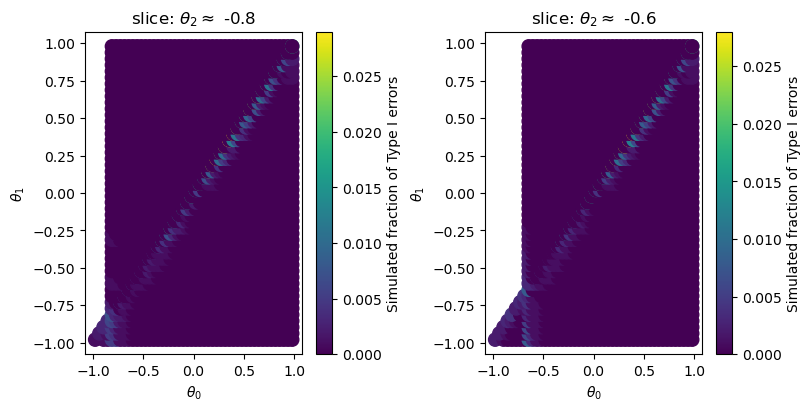

In [30]:
sim_size = sim_batch_size * n_sim_batches

plt.figure(figsize=(8,4), constrained_layout=True)
for i, t2_idx in enumerate([4, 8]):
    t2 = np.unique(theta_tiles[:, 2])[t2_idx]
    selection = (theta_tiles[:,2] == t2)

    plt.subplot(1,2,i+1)
    plt.title(f'slice: $\\theta_2 \\approx$ {t2:.1f}')
    plt.scatter(theta_tiles[selection,0], theta_tiles[selection,1], c=typeI_sum[selection]/sim_size, s=90)
    cbar = plt.colorbar()
    plt.xlabel(r'$\theta_0$')
    plt.ylabel(r'$\theta_1$')
    cbar.set_label('Simulated fraction of Type I errors')
plt.show()

In [68]:
tile_radii = gr.radii[gr.grid_pt_idx]
sim_sizes = np.full(gr.n_tiles, sim_size)
n_arm_samples = (
    params['n_stage_1'] +
    params['n_stage_1_add_per_interim'] // 2 * params['n_stage_1_interims'] + 
    params['n_stage_2'] +
    params['n_stage_2_add_per_interim'] // 2
)
total, d0, d0u, d1w, d1uw, d2uw = binomial.upper_bound(
    theta_tiles,
    tile_radii,
    gr.vertices,
    sim_sizes,
    n_arm_samples,
    typeI_sum,
    typeI_score,
)
bound_components = np.array([
    d0,
    d0u,
    d1w,
    d1uw,
    d2uw,
    total,
]).T

In [79]:
t2_uniques = np.unique(theta_tiles[:, 2])
t3_uniques = np.unique(theta_tiles[:, 3])
t2 = t2_uniques[8]
t3 = t3_uniques[8]
selection = (theta_tiles[:, 2] == t2) & (theta_tiles[:, 3] == t3)

np.savetxt('P_lei.csv', theta_tiles[selection, :].T, fmt="%s", delimiter=",")
np.savetxt('B_lei.csv', bound_components[selection, :], fmt="%s", delimiter=",")

In [80]:
t2_uniques[8], t3_uniques[8]

(0.0625, 0.0625)

# Sandbox